In [ ]:
# %%
# !pip install transformers[torch] datasets evaluate accelerate optuna scikit-learn pandas matplotlib -q
!pip install evaluate optuna
#!pip install -U transformers bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.0 MB/s eta 0:00:00


In [ ]:
# %%
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch, numpy as np, evaluate, torch.nn as nn, torch.nn.functional as F, pandas as pd, matplotlib.pyplot as plt
from torch.quantization import quantize_dynamic
from time import perf_counter
from pathlib import Path
import optuna

In [ ]:
# %%
clinc = load_dataset("clinc_oos", "plus")
teacher_ckpt = "answerdotai/ModernBERT-large"
student_ckpt = "bert-base-uncased"
intents = clinc["test"].features["intent"]
id2label = {i: label for i, label in enumerate(intents.names)}
label2id = {label: i for i, label in enumerate(intents.names)}
num_labels = intents.num_classes

teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_ckpt)
def tokenize_text(batch): return teacher_tokenizer(batch["text"], truncation=True)
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)
def tokenize_text_student(batch): return student_tokenizer(batch["text"], truncation=True)
clinc_enc_student = clinc.map(tokenize_text_student, batched=True, remove_columns=["text"])
clinc_enc_student = clinc_enc_student.rename_column("intent", "labels")

accuracy_score = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
def compute_metrics(pred):
    # 'pred' is an EvalPrediction object
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1) # Convert logits to class IDs

    # Compute Accuracy
    accuracy_result = accuracy_score.compute(predictions=predictions, references=labels)

    # Compute Macro F1 Score
    # For multi-class classification, you must specify the 'average' parameter.
    f1_result = f1_metric.compute(
        predictions=predictions,
        references=labels,
        average="macro" # <-- This calculates the MACRO F1 score
    )

    # Combine results into a single dictionary
    # The keys must match what you are expecting, e.g., 'eval_macro_f1'
    return {
        "accuracy": accuracy_result["accuracy"],
        "macro_f1": f1_result["f1"], # Return 'f1' key from the compute result
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plus/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

plus/validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

plus/test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
teacher_training_args = TrainingArguments(
    output_dir="/kaggle/working/ModernBERT-large-finetuned-clinc",
    eval_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # 明确最佳模型的评价指标
    greater_is_better=True,
    report_to="none",
    save_only_model=True,  # 只保存模型，不保存 optimizer/scheduler
    save_safetensors=True, # safetensors 更安全更快
)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        teacher_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id
    )


teacher_trainer = Trainer(
    model_init=model_init,
    args=teacher_training_args,
    train_dataset=clinc_enc['train'],
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics,
    tokenizer=teacher_tokenizer,
)
teacher_trainer.train()

save_path = "/kaggle/working/ModernBERT-large-finetuned-clinc"
teacher_trainer.save_model(save_path)
teacher_tokenizer.save_pretrained(save_path) # 确保分词器也保存了

/tmp/ipython-input-1078479289.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  teacher_trainer = Trainer(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W1007 18:16:04.418000 1380 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy
1,0.168600,0.218951,0.952258
2,0.038900,0.185589,0.967742
3,0.018800,0.167427,0.969032
4,0.003300,0.165662,0.970323
5,0.000100,0.164647,0.969677


('/kaggle/working/ModernBERT-large-finetuned-clinc/tokenizer_config.json',
 '/kaggle/working/ModernBERT-large-finetuned-clinc/special_tokens_map.json',
 '/kaggle/working/ModernBERT-large-finetuned-clinc/tokenizer.json')

In [ ]:
# 用 trainer 评估编码后的测试集
def tokenize_with_labels(batch):
    tokens = teacher_tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = batch["intent"]
    return tokens

clinc_enc_test = clinc["test"].map(tokenize_with_labels, batched=True)

trainer_metrics = teacher_trainer.evaluate(eval_dataset=clinc_enc_test)
print(trainer_metrics)


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

{'eval_loss': 0.5416863560676575, 'eval_accuracy': 0.9003636363636364, 'eval_runtime': 139.9903, 'eval_samples_per_second': 39.288, 'eval_steps_per_second': 2.457, 'epoch': 5.0}


In [ ]:
print(clinc["test"][0]["text"], clinc["test"][0]["intent"])
print(id2label[clinc["test"][0]["intent"]])


how would you say fly in italian 61
translate


In [ ]:
from huggingface_hub import login
from google.colab import userdata

# 从 Colab Secrets 中读取 HF_TOKEN
HF_TOKEN = userdata.get('colabb')

# 使用令牌登录
if HF_TOKEN:
    login(token=HF_TOKEN)
    print("Successfully logged in to Hugging Face using Colab Secret!")
else:
    print("HF_TOKEN is not set in Colab Secrets.")

Successfully logged in to Hugging Face using Colab Secret!


In [ ]:
teacher_trainer.model.push_to_hub("pine-cone/ModernBERT-large-finetuned-clinc")

teacher_tokenizer.push_to_hub("pine-cone/ModernBERT-large-finetuned-clinc")

NameError: name 'teacher_trainer' is not defined

In [ ]:
pipe_teacher = pipeline(
    "text-classification",
    model="pine-cone/ModernBERT-large-finetuned-clinc",
    tokenizer="pine-cone/ModernBERT-large-finetuned-clinc",
)
query = "Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"
print(pipe_teacher(query))

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'car_rental', 'score': 0.9993919134140015}]


In [ ]:
# %% Distillation trainer
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha, self.temperature = alpha, temperature
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        if self.teacher_model:
            self.teacher_model.to(self.args.device); self.teacher_model.eval()
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs_stu = model(**inputs); loss_ce, logits_stu = outputs_stu.loss, outputs_stu.logits
        with torch.no_grad(): logits_tea = self.teacher_model(**inputs).logits
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature**2 * loss_fct(
            F.log_softmax(logits_stu/self.args.temperature, dim=-1),
            F.softmax(logits_tea/self.args.temperature, dim=-1)
        )
        loss = self.args.alpha*loss_ce + (1.-self.args.alpha)*loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [ ]:
# 设置蒸馏训练参数（固定超参数）
teacher_model = AutoModelForSequenceClassification.from_pretrained("pine-cone/ModernBERT-large-finetuned-clinc")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# !!! 关键步骤：移动到 GPU !!!
teacher_model.to(device)
teacher_model.eval() # 确保它处于评估模式

fixed_args = DistillationTrainingArguments(
    output_dir="/kaggle/working/bert-base-distilled-fixed",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    alpha=0.5,                # 固定蒸馏权重
    temperature=7.0,          # 固定温度
    report_to="none",
    save_only_model=True,
    logging_strategy="steps",
    logging_steps=10,
    gradient_accumulation_steps=2
)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        student_ckpt,
        num_labels=teacher_model.config.num_labels
    )
    # 对齐教师模型标签
    model.config.id2label = teacher_model.config.id2label
    model.config.label2id = teacher_model.config.label2id
    return model

# 创建蒸馏 Trainer
fixed_trainer = DistillationTrainer(
    model_init=model_init,
    teacher_model=teacher_model,
    args=fixed_args,
    train_dataset=clinc_enc_student["train"],
    eval_dataset=clinc_enc_student["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer,
)

# 开始训练
fixed_trainer.train()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

/tmp/ipython-input-1428946420.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.710600,2.612303,0.647742
2,2.089700,2.003171,0.887419
3,1.757900,1.719881,0.924839
4,1.680700,1.636488,0.934839


TrainOutput(global_step=1908, training_loss=2.275734621023982, metrics={'train_runtime': 733.9495, 'train_samples_per_second': 83.112, 'train_steps_per_second': 2.6, 'total_flos': 575587515554556.0, 'train_loss': 2.275734621023982, 'epoch': 4.0})

In [ ]:
# 用 trainer 评估编码后的测试集
clinc_enc_test = clinc["test"].map(
    lambda x: student_tokenizer(x["text"], truncation=True, padding="max_length", max_length=128),
    batched=True
)
trainer_metrics = fixed_trainer.evaluate(eval_dataset=clinc_enc_test)
print(trainer_metrics)


In [ ]:
# 保存模型
output_path = "/kaggle/working/bert-base-distilled-fixed"
fixed_trainer.save_model(output_path)
fixed_trainer.tokenizer.save_pretrained(output_path)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('/kaggle/working/bert-base-distilled-fixed/tokenizer_config.json',
 '/kaggle/working/bert-base-distilled-fixed/special_tokens_map.json',
 '/kaggle/working/bert-base-distilled-fixed/vocab.txt',
 '/kaggle/working/bert-base-distilled-fixed/added_tokens.json',
 '/kaggle/working/bert-base-distilled-fixed/tokenizer.json')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(output_path)
tokenizer = AutoTokenizer.from_pretrained(output_path)

model.push_to_hub("pine-cone/bert-base-distilled-fixed")
tokenizer.push_to_hub("pine-cone/bert-base-distilled-fixed")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...z29e63t/model.safetensors:   8%|7         | 33.5MB /  438MB            

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pine-cone/bert-base-distilled-fixed/commit/ba9819dd8a2faedd06c67f66a55eb846833b75ef', commit_message='Upload tokenizer', commit_description='', oid='ba9819dd8a2faedd06c67f66a55eb846833b75ef', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pine-cone/bert-base-distilled-fixed', endpoint='https://huggingface.co', repo_type='model', repo_id='pine-cone/bert-base-distilled-fixed'), pr_revision=None, pr_num=None)

In [ ]:
# %% Distillation with Optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher_model = AutoModelForSequenceClassification.from_pretrained("pine-cone/ModernBERT-large-finetuned-clinc")

# !!! 关键步骤：移动到 GPU !!!
teacher_model.to(device)
teacher_model.eval() # 确保它处于评估模式

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 1024, padding_idx=50283)
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=1024, out_features=3072, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=1024, out_features=1024, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=1024, out_features=5248, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=2624, out_features=1024, bias=False)
        

In [ ]:
# %% Distillation with Optuna

def hp_space(trial):
    return {
        "learning_rate": 2e-5,                        # 固定
        "num_train_epochs": 8,                        # 固定
        #"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0.4, 0.8),
        #"alpha": trial.suggest_categorical("alpha", [0.5, 0.6, 0.8]),
        "temperature": trial.suggest_categorical("temperature", [4,6,7])
        #"temperature": trial.suggest_float("temperature", 2.0, 12.0)
    }


distil_args = DistillationTrainingArguments(
    output_dir="/kaggle/working/bert-base-distilled-Optuna",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=6,       # 这个会被 Optuna 搜索覆盖
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # 明确最佳模型的评价指标
    greater_is_better=True,            # accuracy 越大越好
    alpha=0.5,                # 初始值，会被 Optuna 搜索覆盖
    temperature=2.0,          # 初始值，会被 Optuna 搜索覆盖
    report_to="none",
    save_only_model=True,
    logging_strategy="steps",
    logging_steps=10,
    gradient_accumulation_steps=2
)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        student_ckpt,
        num_labels=teacher_model.config.num_labels
    )
    # 对齐教师模型标签
    model.config.id2label = teacher_model.config.id2label
    model.config.label2id = teacher_model.config.label2id
    return model

search_trainer = DistillationTrainer(
    model_init=model_init,
    teacher_model=teacher_model,
    args=distil_args,
    train_dataset=clinc_enc_student["train"],
    eval_dataset=clinc_enc_student["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer,
)
best_run = search_trainer.hyperparameter_search(n_trials=6, direction="maximize", hp_space=hp_space)

/tmp/ipython-input-1428946420.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-10-05 12:13:14,458] A new study created in memory with name: no-name-9e28c3db-b767-43dc-be72-209ae6ef33a8
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W1005 12:13:23.144000 1564 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy
1,2.675100,2.523523,0.801290
2,1.688200,1.620851,0.926452
3,1.211600,1.195066,0.945806
4,0.989000,1.011120,0.950968
5,0.865800,0.928689,0.951935
6,0.798600,0.891946,0.952903
7,0.784700,0.874794,0.954194
8,0.775000,0.868798,0.954194


[I 2025-10-05 12:35:48,207] Trial 0 finished with value: 0.9541935483870968 and parameters: {'alpha': 0.630571588388972, 'temperature': 10}. Best is trial 0 with value: 0.9541935483870968.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.704400,2.551690,0.810323
2,1.696400,1.628750,0.925806
3,1.208000,1.192352,0.947097
4,0.986700,1.004799,0.952581
5,0.854700,0.919138,0.954516
6,0.786600,0.880504,0.952581
7,0.773600,0.862128,0.953548
8,0.763700,0.856140,0.953548


[I 2025-10-05 12:58:09,627] Trial 1 finished with value: 0.9535483870967741 and parameters: {'alpha': 0.6412513943521345, 'temperature': 10}. Best is trial 0 with value: 0.9541935483870968.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.788600,2.621471,0.790323
2,1.650300,1.575320,0.922258
3,1.117700,1.111341,0.945484
4,0.891600,0.918064,0.952581
5,0.750200,0.826298,0.956452
6,0.676500,0.789467,0.954516
7,0.663800,0.769091,0.956452
8,0.650200,0.763478,0.955806


[I 2025-10-05 13:20:54,092] Trial 2 finished with value: 0.9558064516129032 and parameters: {'alpha': 0.7209835808782202, 'temperature': 7}. Best is trial 2 with value: 0.9558064516129032.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.667700,2.519986,0.805161


[W 2025-10-05 13:25:43,499] Trial 3 failed with parameters: {'alpha': 0.60521724721018, 'temperature': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/integrations/integration_utils.py", line 277, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2328, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2677, in _inner_training_loop
    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-10-05 13:25:43,501] Trial 3 f

KeyboardInterrupt: 

In [ ]:
#best_params = best_run.hyperparameters
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        student_ckpt,
        num_labels=teacher_model.config.num_labels
    )
    # 对齐教师模型标签
    model.config.id2label = teacher_model.config.id2label
    model.config.label2id = teacher_model.config.label2id
    return model

# ✅ Step 1: 创建新的训练参数对象，填入最优 α / T
best_args = DistillationTrainingArguments(
    output_dir="/kaggle/working/bert-base-distilled-final",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,               # 这个是固定值（如果没调）
    num_train_epochs=8,               # 或者你也可以用 best_params 里的
    weight_decay=0.01,
    warmup_ratio=0.06,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="none",
    logging_strategy="steps",
    logging_steps=10,
    gradient_accumulation_steps=2,

    # 🔥 用最优超参覆盖
    alpha=0.724672262749978,#best_params["alpha"],
    temperature=7#best_params["temperature"]
)

# ✅ Step 2: 初始化模型
best_model = model_init()

# ✅ Step 3: 新 Trainer（最终训练）
final_trainer = DistillationTrainer(
    model=best_model,
    teacher_model=teacher_model,
    args=best_args,
    train_dataset=clinc_enc_student["train"],
    eval_dataset=clinc_enc_student["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

# ✅ Step 4: 重新训练（用最优超参）
final_trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1428946420.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
W1008 12:35:31.063000 1475 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,2.987700,2.848179,0.760968,0.749750
2,1.685000,1.608866,0.914194,0.917152
3,1.122100,1.092647,0.943871,0.948558
4,0.862700,0.886773,0.950645,0.955031
5,0.718800,0.798898,0.953548,0.958233
6,0.641000,0.758899,0.954194,0.958709
7,0.632800,0.737825,0.955161,0.959764
8,0.626700,0.733441,0.953871,0.958537


TrainOutput(global_step=3816, training_loss=1.3709464952880732, metrics={'train_runtime': 1605.7092, 'train_samples_per_second': 75.979, 'train_steps_per_second': 2.377, 'total_flos': 1149331818924300.0, 'train_loss': 1.3709464952880732, 'epoch': 8.0})

In [ ]:
# 用 trainer 评估编码后的测试集
def tokenize_with_labels(batch):
    tokens = student_tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = batch["intent"]
    return tokens

clinc_enc_test = clinc["test"].map(tokenize_with_labels, batched=True)

trainer_metrics = final_trainer.evaluate(eval_dataset=clinc_enc_test)
print(trainer_metrics)



Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

{'eval_loss': 0.8634978532791138, 'eval_accuracy': 0.9056363636363637, 'eval_macro_f1': 0.9282288173816916, 'eval_runtime': 196.1271, 'eval_samples_per_second': 28.043, 'eval_steps_per_second': 1.754, 'epoch': 8.0}


In [ ]:
output_path = "/kaggle/working/bert-base-distilled-final"
final_trainer.save_model(output_path)
final_trainer.tokenizer.save_pretrained(output_path)


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('/kaggle/working/bert-base-distilled-final/tokenizer_config.json',
 '/kaggle/working/bert-base-distilled-final/special_tokens_map.json',
 '/kaggle/working/bert-base-distilled-final/vocab.txt',
 '/kaggle/working/bert-base-distilled-final/added_tokens.json',
 '/kaggle/working/bert-base-distilled-final/tokenizer.json')

In [ ]:


final_model = final_trainer.model
final_tokenizer = student_tokenizer

final_model.push_to_hub("pine-cone/bert-base-distilled-Optuna")
final_tokenizer.push_to_hub("pine-cone/bert-base-distilled-Optuna")
#output_path = best_run.checkpoint
#model = AutoModelForSequenceClassification.from_pretrained(output_path)
#tokenizer = AutoTokenizer.from_pretrained(output_path)

#model.push_to_hub("pine-cone/bert-base-distilled-Optuna")
#tokenizer.push_to_hub("pine-cone/bert-base-distilled-Optuna")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...v8wh1ci/model.safetensors:   0%|          | 14.2kB /  438MB            

CommitInfo(commit_url='https://huggingface.co/pine-cone/bert-base-distilled-Optuna/commit/b3a74bc2360c2e9184b19e47e28f177f87d0a0e1', commit_message='Upload tokenizer', commit_description='', oid='b3a74bc2360c2e9184b19e47e28f177f87d0a0e1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pine-cone/bert-base-distilled-Optuna', endpoint='https://huggingface.co', repo_type='model', repo_id='pine-cone/bert-base-distilled-Optuna'), pr_revision=None, pr_num=None)

In [ ]:
# %% Benchmark class
clinc = load_dataset("clinc_oos", "plus")
test_ds = clinc["test"]
intents = test_ds.features["intent"]
accuracy_score = evaluate.load("accuracy")

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type):
        self.pipeline, self.dataset, self.optim_type = pipeline, dataset, optim_type
    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"]
            #preds.append(intents.str2int(pred)); labels.append(example["intent"])
            pred_label = pred.replace("LABEL_", "")
            pred_idx = int(pred_label) if pred_label.isdigit() else intents.str2int(pred_label)
            preds.append(pred_idx)
            labels.append(example["intent"])

        return accuracy_score.compute(predictions=preds, references=labels)
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt"); torch.save(state_dict, tmp_path)
        size_mb = Path(tmp_path).stat().st_size/(1024*1024); tmp_path.unlink()
        return {"size_mb": size_mb}
    def time_pipeline(self, query="What is the pin number for my account?"):
        for _ in range(10): _ = self.pipeline(query)
        latencies = []
        for _ in range(100):
            start = perf_counter(); _ = self.pipeline(query); latencies.append(perf_counter()-start)
        return {"time_avg_ms": 1000*np.mean(latencies), "time_std_ms": 1000*np.std(latencies)}
    def run_benchmark(self):
        m = {}; m[self.optim_type] = {}
        m[self.optim_type].update(self.compute_size())
        m[self.optim_type].update(self.time_pipeline())
        m[self.optim_type].update(self.compute_accuracy())
        return m

perf_metrics = {}

model_path = "pine-cone/ModernBERT-large-finetuned-clinc"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
pipe_teacher_cpu = pipeline(
    "text-classification",
    model=model,
    tokenizer=model_path,
    device=-1  # CPU
)

pb = PerformanceBenchmark(pipe_teacher_cpu, clinc["test"], "ModernBERT-large")
perf_metrics.update(pb.run_benchmark())

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# 推理管道与性能评估

model_path = "pine-cone/bert-base-distilled-fixed"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
pipe_fixed_cpu = pipeline(
    "text-classification",
    model=model,
    tokenizer=model_path,
    device=-1
)

pb = PerformanceBenchmark(pipe_fixed_cpu, clinc["test"], "Distillation-Fixed")
perf_metrics.update(pb.run_benchmark())

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:

model_path = "pine-cone/bert-base-distilled-final"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
pipe_distilled_cpu = pipeline(
    "text-classification",
    model=model,
    tokenizer=model_path,
    device=-1
)

pb = PerformanceBenchmark(pipe_distilled_cpu, clinc["test"], "Distillation-Optuna")
perf_metrics.update(pb.run_benchmark())

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# %% Quantization
model_name = "pine-cone/bert-base-distilled-Optuna"
output_path = "/kaggle/working/bert-base-distilled-final"
model_distilled = AutoModelForSequenceClassification.from_pretrained(output_path).to("cpu")
model_distilled.eval()
model_quantized = quantize_dynamic(model_distilled, {torch.nn.Linear}, dtype=torch.qint8)

pipe_quantized_cpu = pipeline(
    "text-classification",
    model=model_quantized,
    tokenizer=output_path,
    device=-1
)
model.eval()

pb = PerformanceBenchmark(pipe_quantized_cpu, clinc["test"], "Distillation+Quantization")
perf_metrics.update(pb.run_benchmark())

/tmp/ipython-input-2551072981.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(model_distilled, {torch.nn.Linear}, dtype=torch.qint8)
Device set to use cpu


In [ ]:
# %% Plot results
final_df = pd.DataFrame.from_dict(perf_metrics, orient='index')
print(final_df)

                               size_mb  time_avg_ms  time_std_ms  accuracy
ModernBERT-large           1510.624507   521.414343   137.759554  0.915091
Distillation-Fixed          418.147475   116.434022     9.250822  0.902182
Distillation-Optuna         418.147475   117.118999     8.689499  0.907818
Distillation+Quantization   173.182982    30.170859     2.525748  0.904182


{'ModernBERT-large': {'size_mb': 1510.6245069503784, 'time_avg_ms': np.float64(521.4143433500021), 'time_std_ms': np.float64(137.75955356985162), 'accuracy': 0.9150909090909091}, 'Distillation-Fixed': {'size_mb': 418.14747524261475, 'time_avg_ms': np.float64(116.43402199993034), 'time_std_ms': np.float64(9.25082160549758), 'accuracy': 0.9021818181818182}, 'Distillation-Optuna': {'size_mb': 418.14747524261475, 'time_avg_ms': np.float64(117.11899852006354), 'time_std_ms': np.float64(8.68949877545423), 'accuracy': 0.9078181818181819}, 'Distillation+Quantization': {'size_mb': 173.18298244476318, 'time_avg_ms': np.float64(30.170859379968533), 'time_std_ms': np.float64(2.525747845033886), 'accuracy': 0.9041818181818182}}


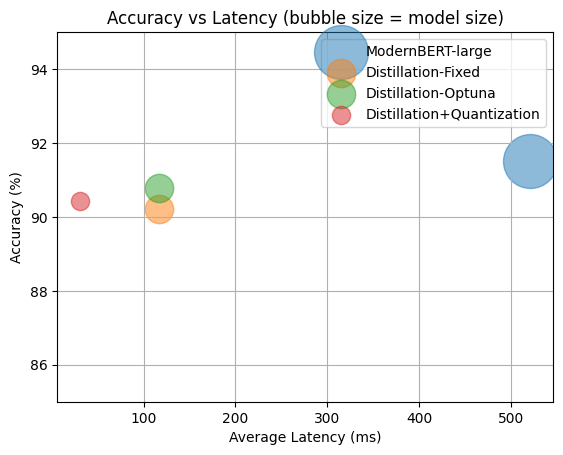

In [ ]:
%matplotlib inline
print(perf_metrics)

def plot_metrics(perf_metrics, current_optim_type=None):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    plt.legend(bbox_to_anchor=(1,1))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average Latency (ms)")
    plt.title("Accuracy vs Latency (bubble size = model size)")
    plt.ylim(85, 95)  # 或自动根据结果范围设定
    plt.grid(True)
    plt.show()

plot_metrics(perf_metrics, current_optim_type="DistilBERT")
